In [70]:
import pandas as pd

import numpy as np

import sklearn
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import Pipeline , FeatureUnion
from sklearn.base import BaseEstimator , TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    PowerTransformer,
    StandardScaler,
    FunctionTransformer)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.outliers import Winsorizer 
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 1.Display Setting 

In [2]:
pd.set_option('display.max_columns' , None)
sklearn.set_config(transform_output='pandas')
warnings.filterwarnings('ignore')

## 2.Read Data

In [3]:
path = 'H:\\Projects\\Flight-Price_Prediction\\Data'

flight_df = pd.read_csv(path + '\\train.csv')

In [4]:
flight_df.head(8)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-24,Delhi,Cochin,13:00:00,19:15:00,375,1.0,No Info,8372
1,Jet Airways,2019-04-01,Banglore,Delhi,07:10:00,10:10:00,180,0.0,No Info,7229
2,Jet Airways,2019-06-01,Delhi,Cochin,09:40:00,04:25:00,1125,2.0,No Info,13014
3,Jet Airways,2019-04-21,Banglore,Delhi,15:15:00,18:10:00,175,0.0,No Info,7229
4,Vistara,2019-05-15,Banglore,Delhi,07:00:00,09:40:00,160,0.0,No Info,4668
5,Multiple Carriers,2019-06-12,Delhi,Cochin,04:55:00,12:35:00,460,1.0,No Info,10678
6,Indigo,2019-05-12,Kolkata,Banglore,09:35:00,12:20:00,165,0.0,No Info,4804
7,Jet Airways,2019-05-21,Delhi,Cochin,20:55:00,04:25:00,450,1.0,No Info,16079


In [5]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [6]:
X_train = flight_df.drop(columns='price')
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Air India,2019-06-24,Delhi,Cochin,13:00:00,19:15:00,375,1.0,No Info
1,Jet Airways,2019-04-01,Banglore,Delhi,07:10:00,10:10:00,180,0.0,No Info
2,Jet Airways,2019-06-01,Delhi,Cochin,09:40:00,04:25:00,1125,2.0,No Info
3,Jet Airways,2019-04-21,Banglore,Delhi,15:15:00,18:10:00,175,0.0,No Info
4,Vistara,2019-05-15,Banglore,Delhi,07:00:00,09:40:00,160,0.0,No Info
...,...,...,...,...,...,...,...,...,...
635,Indigo,2019-06-27,Delhi,Cochin,14:25:00,17:40:00,195,0.0,No Info
636,Jet Airways,2019-05-27,Delhi,Cochin,11:40:00,19:00:00,440,2.0,In-flight meal not included
637,Jet Airways,2019-05-27,Delhi,Cochin,18:15:00,19:00:00,1485,1.0,In-flight meal not included
638,Jet Airways,2019-03-18,Banglore,New Delhi,08:55:00,16:10:00,435,1.0,No Info


In [7]:
Y_train = flight_df['price'].copy()
Y_train

0       8372
1       7229
2      13014
3       7229
4       4668
       ...  
635     5000
636    19644
637    12898
638    12284
639     4544
Name: price, Length: 640, dtype: int64

## 3.Transformation Operations

#### 3.1 -airline

In [8]:
flight_df.airline

0        Air India
1      Jet Airways
2      Jet Airways
3      Jet Airways
4          Vistara
          ...     
635         Indigo
636    Jet Airways
637    Jet Airways
638    Jet Airways
639    Jet Airways
Name: airline, Length: 640, dtype: object

In [9]:
air_transformer = Pipeline(steps=[
    ('imputer' , SimpleImputer(strategy='most_frequent')),
    ('grouper' , RareLabelEncoder(tol = 0.1 , n_categories= 2, replace_with='Others')),
    ('enoder' , OneHotEncoder(sparse_output=False , handle_unknown='ignore'))
])

air_transformer.fit_transform(X_train.loc[:,['airline']])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Others
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,0.0,1.0,0.0,0.0
638,0.0,0.0,1.0,0.0,0.0


#### 3.2 date_of_journey

In [10]:
flight_df.date_of_journey

0      2019-06-24
1      2019-04-01
2      2019-06-01
3      2019-04-21
4      2019-05-15
          ...    
635    2019-06-27
636    2019-05-27
637    2019-05-27
638    2019-03-18
639    2019-04-09
Name: date_of_journey, Length: 640, dtype: object

In [11]:
fea_to_ext = ['month','week' , 'day_of_week' , 'day_of_year']

doj_transformer =  Pipeline(steps=[
    ('dt' , DatetimeFeatures(features_to_extract=fea_to_ext , yearfirst=True , format='mixed')),
    ('scaler' , MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,1.000000,0.000000,0.974576
1,0.333333,0.294118,0.000000,0.262712
2,1.000000,0.764706,0.833333,0.779661
3,0.333333,0.411765,1.000000,0.432203
4,0.666667,0.647059,0.333333,0.635593
...,...,...,...,...
635,1.000000,1.000000,0.500000,1.000000
636,0.666667,0.764706,0.000000,0.737288
637,0.666667,0.764706,0.000000,0.737288
638,0.000000,0.176471,0.000000,0.144068


#### 3.3 source

In [12]:
flight_df.source

0         Delhi
1      Banglore
2         Delhi
3      Banglore
4      Banglore
         ...   
635       Delhi
636       Delhi
637       Delhi
638    Banglore
639    Banglore
Name: source, Length: 640, dtype: object

In [13]:
flight_df.destination

0         Cochin
1          Delhi
2         Cochin
3          Delhi
4          Delhi
         ...    
635       Cochin
636       Cochin
637       Cochin
638    New Delhi
639        Delhi
Name: destination, Length: 640, dtype: object

In [14]:
flight_df.source.unique

<bound method Series.unique of 0         Delhi
1      Banglore
2         Delhi
3      Banglore
4      Banglore
         ...   
635       Delhi
636       Delhi
637       Delhi
638    Banglore
639    Banglore
Name: source, Length: 640, dtype: object>

In [15]:
locations  = X_train.loc[:,['source' , 'destination']]
locations

,source,destination
0,Delhi,Cochin
1,Banglore,Delhi
2,Delhi,Cochin
3,Banglore,Delhi
4,Banglore,Delhi
...,...,...
635,Delhi,Cochin
636,Delhi,Cochin
637,Delhi,Cochin
638,Banglore,New Delhi


In [16]:
S_D_transformer = Pipeline(steps=[
    ('grouper' , RareLabelEncoder(tol = 0.1 , replace_with='Others' , n_categories= 2)),
    ('encoder' , MeanEncoder()),
    ('scaler' , PowerTransformer()) 
])

S_D_transformer.fit_transform(locations , Y_train)

,source,destination
0,1.012691,1.017954
1,-0.788435,-1.882981
2,1.012691,1.017954
3,-0.788435,-1.882981
4,-0.788435,-1.882981
...,...,...
635,1.012691,1.017954
636,1.012691,1.017954
637,1.012691,1.017954
638,-0.788435,-0.916247


In [17]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [18]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ['Delhi' , 'Kolkata' , 'Mumbai' , 'New Delhi' ]
    return (
        X
        .assign(**{
            f'{col}_is_north': X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns= columns)
    )

FunctionTransformer(func=is_north).fit_transform(locations)

,source_is_north,destination_is_north
0,1,0
1,0,1
2,1,0
3,0,1
4,0,1
...,...,...
635,1,0
636,1,0
637,1,0
638,0,1


In [19]:
location_transformer = FeatureUnion(transformer_list=[
    ('part1' , S_D_transformer) ,
    ('part2' , FunctionTransformer(func=is_north))
])
location_transformer.fit_transform(locations , Y_train)

,source,destination,source_is_north,destination_is_north
0,1.012691,1.017954,1,0
1,-0.788435,-1.882981,0,1
2,1.012691,1.017954,1,0
3,-0.788435,-1.882981,0,1
4,-0.788435,-1.882981,0,1
...,...,...,...,...
635,1.012691,1.017954,1,0
636,1.012691,1.017954,1,0
637,1.012691,1.017954,1,0
638,-0.788435,-0.916247,0,1


#### 3.4 dep_time & arrival_time

In [20]:
flight_df.dep_time

0      13:00:00
1      07:10:00
2      09:40:00
3      15:15:00
4      07:00:00
         ...   
635    14:25:00
636    11:40:00
637    18:15:00
638    08:55:00
639    08:20:00
Name: dep_time, Length: 640, dtype: object

In [21]:
time_subset = X_train.loc[:,['dep_time' , 'arrival_time']]
time_subset

,dep_time,arrival_time
0,13:00:00,19:15:00
1,07:10:00,10:10:00
2,09:40:00,04:25:00
3,15:15:00,18:10:00
4,07:00:00,09:40:00
...,...,...
635,14:25:00,17:40:00
636,11:40:00,19:00:00
637,18:15:00,19:00:00
638,08:55:00,16:10:00


In [22]:
time_pipe1 = Pipeline(steps=[
    ('dt' , DatetimeFeatures(features_to_extract=['hour' , 'minute'])),
    ('scaler' , MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.565217,0.000000,0.826087,0.272727
1,0.304348,0.181818,0.434783,0.181818
2,0.391304,0.727273,0.173913,0.454545
3,0.652174,0.272727,0.782609,0.181818
4,0.304348,0.000000,0.391304,0.727273
...,...,...,...,...
635,0.608696,0.454545,0.739130,0.727273
636,0.478261,0.727273,0.826087,0.000000
637,0.782609,0.272727,0.826087,0.000000
638,0.347826,1.000000,0.695652,0.181818


In [23]:
def part_of_Day(X , morning=4 , noon=12 , eve=16 , night = 20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col : pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f'{col}_part_of_day' : np.select(
                [X_temp.loc[:,col].between(morning , noon , inclusive = 'left'),
                X_temp.loc[:, col].between(noon , eve , inclusive = 'left'),
                X_temp.loc[:, col].between (eve , night , inclusive='left')],
                ['morning' , 'afternoon' , 'evening'],
                default = 'night'
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_Day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,afternoon,evening
1,morning,morning
2,morning,morning
3,afternoon,evening
4,morning,morning
...,...,...
635,afternoon,evening
636,morning,evening
637,evening,evening
638,morning,evening


In [24]:
time_pipe2 = Pipeline(steps=[
    ('part' , FunctionTransformer(func=part_of_Day)),
    ('encoder' , CountFrequencyEncoder()),
    ('scaler' , MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.000000,0.861386
1,1.000000,1.000000
2,1.000000,1.000000
3,0.000000,0.861386
4,1.000000,1.000000
...,...,...
635,0.000000,0.861386
636,1.000000,0.861386
637,0.203046,0.861386
638,1.000000,0.861386


In [25]:
time_transformer = FeatureUnion(transformer_list=[
    ('part1' , time_pipe1),
    ('part2' , time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.565217,0.000000,0.826087,0.272727,0.000000,0.861386
1,0.304348,0.181818,0.434783,0.181818,1.000000,1.000000
2,0.391304,0.727273,0.173913,0.454545,1.000000,1.000000
3,0.652174,0.272727,0.782609,0.181818,0.000000,0.861386
4,0.304348,0.000000,0.391304,0.727273,1.000000,1.000000
...,...,...,...,...,...,...
635,0.608696,0.454545,0.739130,0.727273,0.000000,0.861386
636,0.478261,0.727273,0.826087,0.000000,1.000000,0.861386
637,0.782609,0.272727,0.826087,0.000000,0.203046,0.861386
638,0.347826,1.000000,0.695652,0.181818,1.000000,0.861386


#### 3.5 duration

In [26]:
(
    X_train
    .duration
    .quantile([0.25 , 0.5 , 0.75])
    .values
    .reshape(-1,1)
    .shape
)

(3, 1)

In [27]:
class RBFPercentileSimilarity(BaseEstimator , TransformerMixin):
    def __init__(self , variables=None , percentiles=[0.25 , 0.5 , 0.75] , gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma

    def fit(self , X , y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include = 'number').columns.to_list()

        self.reference_values_ = {
            col: (
                X
                .loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1 , 1)
            )
            for col in self.variables
        }

        return self

    def transform(self , X):
        objects = []
        for col in self.variables:
            columns = [f'{col}_rbf_{int(percentile * 100)}' for percentile in self.percentiles]
            obj = pd.DataFrame(
                data = rbf_kernel(X.loc[:, [col]] , Y = self.reference_values_[col] , gamma = self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects , axis=1)            

In [28]:
RBFPercentileSimilarity(percentiles=[0.4 , 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,1.691898e-10,0.000000e+00,1.000000,1.000000
1,0.000000e+00,0.000000e+00,0.904837,0.904837
2,0.000000e+00,5.073772e-48,0.904837,0.904837
3,0.000000e+00,0.000000e+00,0.904837,0.904837
4,0.000000e+00,0.000000e+00,0.904837,0.904837
...,...,...,...,...
635,0.000000e+00,0.000000e+00,0.904837,0.904837
636,2.669190e-109,0.000000e+00,0.904837,0.904837
637,0.000000e+00,0.000000e+00,1.000000,1.000000
638,1.135971e-88,0.000000e+00,1.000000,1.000000


In [29]:
def duration_category(X , short=180 , med= 400):
    return(
        X.assign(duration_cat = np.select([X.duration.lt(short),
                                          X.duration.between(short , med , inclusive='left')],
                                         ['short' , 'medium'] ,
                                         default = 'long'))
        .drop(columns= 'duration')
    )

In [52]:
def is_over(X , value= 1000):
    return (
     X
     .assign(**{
         f'duration_over_{value}': X.duration.ge(value).astype(int)
     })
     .drop(columns = 'duration')
    )

In [56]:
duration_pipe1 = Pipeline(steps=[
    ('rbf' , RBFPercentileSimilarity()),
    ('scaler' , PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ('cat' , FunctionTransformer(func=duration_category)),
    ('encoder' , OrdinalEncoder(categories=[['short' , 'medium' , 'long']]))
])

duration_union = FeatureUnion(transformer_list=[
    ('part1' , duration_pipe1),
    ('part2' , duration_pipe2),
    ('part3' , FunctionTransformer(func=is_over)),
    ('part4' , StandardScaler())
])

duration_transformer  = Pipeline(steps=[
    ('outliers' , Winsorizer(capping_method='iqr' , fold=1.5) ),
    ('imputer' , SimpleImputer(strategy='median')),
    ('union' , duration_union)

])

duration_transformer.fit_transform(X_train.loc[:, ['duration']])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.353074,-0.134493,-0.105295,1.0,0,-0.535040
1,2.763506,-0.134493,-0.105295,1.0,0,-0.926795
2,-0.353074,-0.134493,-0.105295,2.0,1,0.971711
3,3.021588,-0.134493,-0.105295,0.0,0,-0.936840
4,-0.353074,-0.134493,-0.105295,0.0,0,-0.966975
...,...,...,...,...,...,...
635,-0.353074,-0.134493,-0.105295,1.0,0,-0.896660
636,-0.353074,-0.134493,-0.105295,2.0,0,-0.404455
637,-0.353074,-0.134493,-0.105295,2.0,1,1.694952
638,-0.353074,-0.134493,-0.105295,2.0,0,-0.414500


#### 3.5 total_step

In [57]:
flight_df.total_stops

0      1.0
1      0.0
2      2.0
3      0.0
4      0.0
      ... 
635    0.0
636    2.0
637    1.0
638    1.0
639    0.0
Name: total_stops, Length: 640, dtype: float64

In [58]:
def is_direct(X):
    return(
        X
        .assign(is_direct_flight = X.total_stops.eq(0).astype(int))
    )

total_stops_transformer = Pipeline(steps=[
    ('impute' , SimpleImputer(strategy='most_frequent')),
    ('' , FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:,['total_stops']])

,total_stops,is_direct_flight
0,1.0,0
1,0.0,1
2,2.0,0
3,0.0,1
4,0.0,1
...,...,...
635,0.0,1
636,2.0,0
637,1.0,0
638,1.0,0


#### 4.7 additional_info

In [59]:
flight_df.additional_info

0                          No Info
1                          No Info
2                          No Info
3                          No Info
4                          No Info
                  ...             
635                        No Info
636    In-flight meal not included
637    In-flight meal not included
638                        No Info
639    In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [60]:
info_pipe1 = Pipeline(steps=[
    ('group' , RareLabelEncoder(tol = 0.1 , n_categories=2 , replace_with='Other')),
    ('encoder' , OneHotEncoder(handle_unknown='ignore' , sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,1.0,0.0,0.0
637,1.0,0.0,0.0
638,0.0,1.0,0.0


In [61]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [62]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [63]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,1.0,0.0,0.0,1
637,1.0,0.0,0.0,1
638,0.0,1.0,0.0,0


## 4.Column Transform

In [64]:
Column_Transformer = ColumnTransformer(transformers=[
    ('air' , air_transformer , ['airline']),
    ('doj' , doj_transformer , ['date_of_journey']),
    ('location' , location_transformer , ['source' , 'destination']),
    ('time' , time_transformer , ['dep_time' , 'arrival_time']),
    ('dur' , duration_transformer , ['duration']),
    ("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder=  'passthrough')

Column_Transformer.fit_transform(X_train , Y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Others,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.974576,1.012691,1.017954,1,0,0.565217,0.000000,0.826087,0.272727,0.000000,0.861386,-0.353074,-0.134493,-0.105295,1.0,0,-0.535040,1.0,0,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,-0.788435,-1.882981,0,1,0.304348,0.181818,0.434783,0.181818,1.000000,1.000000,2.763506,-0.134493,-0.105295,1.0,0,-0.926795,0.0,1,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,1.012691,1.017954,1,0,0.391304,0.727273,0.173913,0.454545,1.000000,1.000000,-0.353074,-0.134493,-0.105295,2.0,1,0.971711,2.0,0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,0.333333,0.411765,1.000000,0.432203,-0.788435,-1.882981,0,1,0.652174,0.272727,0.782609,0.181818,0.000000,0.861386,3.021588,-0.134493,-0.105295,0.0,0,-0.936840,0.0,1,0.0,1.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,0.666667,0.647059,0.333333,0.635593,-0.788435,-1.882981,0,1,0.304348,0.000000,0.391304,0.727273,1.000000,1.000000,-0.353074,-0.134493,-0.105295,0.0,0,-0.966975,0.0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0,1.000000,1.000000,0.500000,1.000000,1.012691,1.017954,1,0,0.608696,0.454545,0.739130,0.727273,0.000000,0.861386,-0.353074,-0.134493,-0.105295,1.0,0,-0.896660,0.0,1,0.0,1.0,0.0,0
636,0.0,0.0,1.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,1.012691,1.017954,1,0,0.478261,0.727273,0.826087,0.000000,1.000000,0.861386,-0.353074,-0.134493,-0.105295,2.0,0,-0.404455,2.0,0,1.0,0.0,0.0,1
637,0.0,0.0,1.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,1.012691,1.017954,1,0,0.782609,0.272727,0.826087,0.000000,0.203046,0.861386,-0.353074,-0.134493,-0.105295,2.0,1,1.694952,1.0,0,1.0,0.0,0.0,1
638,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.000000,0.144068,-0.788435,-0.916247,0,1,0.347826,1.000000,0.695652,0.181818,1.000000,0.861386,-0.353074,-0.134493,-0.105295,2.0,0,-0.414500,1.0,0,0.0,1.0,0.0,0


## 5. Feature selection

In [65]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
)

## 6. Putting it all together 

In [66]:
preprocessor = Pipeline(steps=[
	("ct", Column_Transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, Y_train)

,air__airline_Indigo,air__airline_Jet Airways,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,1.000000,0.974576,1.012691,1.017954,1.0,0,-0.535040,1.0,0
1,0.0,1.0,0.294118,0.262712,-0.788435,-1.882981,1.0,0,-0.926795,0.0,1
2,0.0,1.0,0.764706,0.779661,1.012691,1.017954,2.0,1,0.971711,2.0,0
3,0.0,1.0,0.411765,0.432203,-0.788435,-1.882981,0.0,0,-0.936840,0.0,1
4,0.0,0.0,0.647059,0.635593,-0.788435,-1.882981,0.0,0,-0.966975,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,0.0,1.000000,1.000000,1.012691,1.017954,1.0,0,-0.896660,0.0,1
636,0.0,1.0,0.764706,0.737288,1.012691,1.017954,2.0,0,-0.404455,2.0,0
637,0.0,1.0,0.764706,0.737288,1.012691,1.017954,2.0,1,1.694952,1.0,0
638,0.0,1.0,0.176471,0.144068,-0.788435,-0.916247,2.0,0,-0.414500,1.0,0


### 7. Visualization 

In [67]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.0045629654012132965,
 'air__airline_Indigo': 0.16210165455705292,
 'air__airline_Jet Airways': 0.16625921184043088,
 'air__airline_Multiple Carriers': 0.009349704629880717,
 'air__airline_Others': 0.08993227785915765,
 'doj__date_of_journey_month': 0.06741174404828791,
 'doj__date_of_journey_week': 0.16643134953456665,
 'doj__date_of_journey_day_of_week': -0.05307695983427463,
 'doj__date_of_journey_day_of_year': 0.19568131959103952,
 'location__source': 0.14054529859124998,
 'location__destination': 0.11476205978004494,
 'location__source_is_north': 0.01291650714298113,
 'location__destination_is_north': 0.01291650714298113,
 'time__dep_time_hour': -0.0012678114778098548,
 'time__dep_time_minute': 0.01107800166459986,
 'time__arrival_time_hour': 0.05114980774463962,
 'time__arrival_time_minute': 0.004586414562698482,
 'time__dep_time_part_of_day': -0.019708885024610545,
 'time__arrival_time_part_of_day': 0.008851313401979755,
 'dur__duration_rbf_25': 0.09

In [68]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'doj__date_of_journey_day_of_week': -0.05307695983427463,
 'time__dep_time_part_of_day': -0.019708885024610545,
 'dur__duration_rbf_75': -0.01187922079330069,
 'info__additional_info_No Info': -0.006375408321943239,
 'info__additional_info': -0.006375408321943239,
 'info__additional_info_In-flight meal not included': -0.005405563769491343,
 'dur__duration_rbf_50': -0.004951003857817253,
 'air__airline_Air India': -0.0045629654012132965,
 'time__dep_time_hour': -0.0012678114778098548,
 'time__arrival_time_minute': 0.004586414562698482,
 'time__arrival_time_part_of_day': 0.008851313401979755,
 'air__airline_Multiple Carriers': 0.009349704629880717,
 'time__dep_time_minute': 0.01107800166459986,
 'location__source_is_north': 0.01291650714298113,
 'location__destination_is_north': 0.01291650714298113,
 'info__additional_info_Other': 0.013993453200803549,
 'time__arrival_time_hour': 0.05114980774463962,
 'doj__date_of_journey_month': 0.06741174404828791,
 'air__airline_Others': 0.089932277

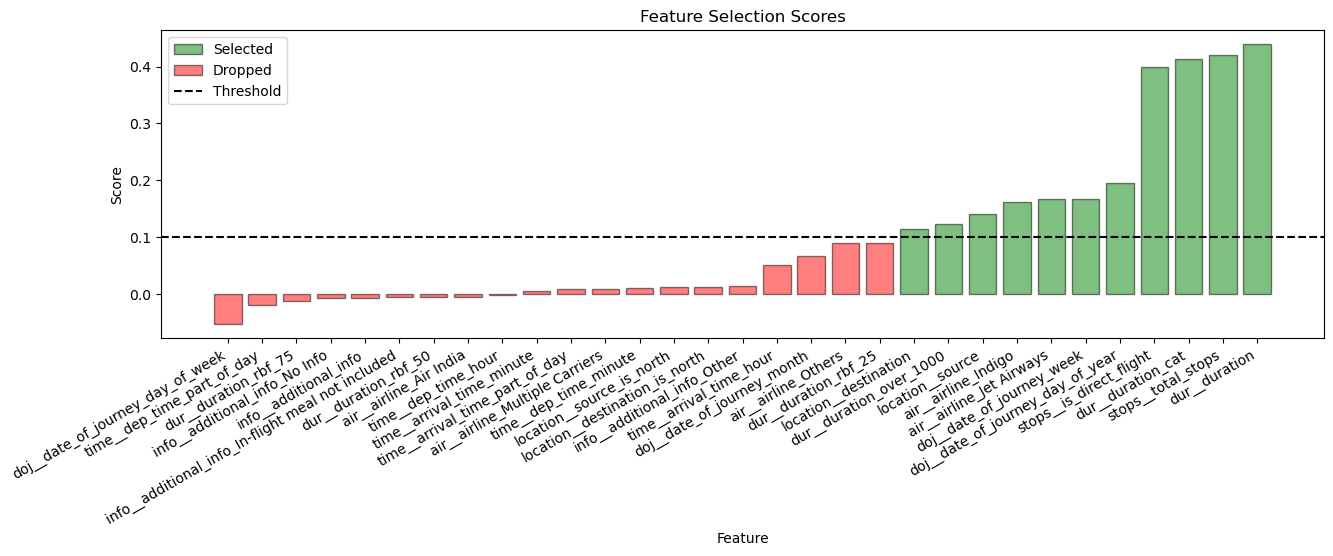

In [71]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()